# Modelo de reconocimiento de letras

Por medio del uso del dataset que se encuentra en [keggle](https://www.kaggle.com/datasets/landlord/handwriting-recognition?resource=download), se desea construir un modelo de inteligencia artificial que proporcione la capacidad de analizar entrada de escritura a mano por medio de una entrada por mouse (Para esto se usará tensorflow.js que permite exportar el modelo para usarlo en el navegador de forma sencilla).

## Entrenamiento de dígitos

Para poder entrenar el modelo en el reconocimiento de letras individuales se usará la base de datos [EMNIST](https://www.kaggle.com/datasets/crawford/emnist?resource=download) lo cual nos ayudará a posteriormente entrenar el model en identificar las letras de cada uno de las palabras. Por lo cual será necesario el uso de los siguientes paquetes para crear y entrenar el modelo.

In [2]:
import cv2, os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tf_keras import layers, losses, models, metrics
DATASET_JONAS = "dataset/archive"
DATASET_JONAS2 = "dataset/second"
DATASET_EMNIST = "https://biometrics.nist.gov/cs_links/EMNIST/gzip.zip"
np.set_printoptions(precision=3, suppress=True)

### Funciones de normalización

Estas funciones nos ayudarán a poder realizar acciones que pueden ser repetidas varias veces, ya sea entrenando el modelo o incluso normalizando la información para poder entrenar al modelo.

In [3]:
def normalize(image):
    return image/255.

def norm2(images):
    aux = []
    for i in range(0,images.__len__()):
        imagen_for = images.iloc[i].to_numpy().reshape([28,28])
        imagen_for = cv2.flip(imagen_for, 1) 
        imagen_for = cv2.rotate(imagen_for, cv2.ROTATE_90_COUNTERCLOCKWISE)
        aux.append(imagen_for)
    return aux

def norm(value, label):
    val = tf.cast(value, tf.float32)
    val = tf.expand_dims(val, axis=-1)
    return val, label

def grafic(modelo):
    plt.xlabel("Épocas")
    plt.ylabel("Pérdida")
    plt.plot(modelo.history["loss"], label="Datos de entrenamiento")
    plt.plot(modelo.history["val_loss"], label="Datos de prueba")
    plt.legend(loc="upper right")
    plt.ylim([0,1])
    plt.show()

### Arquitectura del modelo

El modelo sigue la estructura de perceptrón multicapa (MLP) donde se tiene 

In [4]:
# Modelo
m = models.Sequential(layers=[
    layers.Flatten(input_shape=(28,28,)),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(125, activation='relu'),
    layers.Dropout(0.03),
    layers.Dense(27, activation='softmax')])

m.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[metrics.SparseCategoricalAccuracy()])
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 125)               98125     
                                                                 
 dropout (Dropout)           (None, 125)               0         
                                                                 
 dense_1 (Dense)             (None, 125)               15750     
                                                                 
 dropout_1 (Dropout)         (None, 125)               0         
                                                                 
 dense_2 (Dense)             (None, 125)               15750     
                                                                 
 dropout_2 (Dropout)         (None, 125)               0

In [5]:
i=1
df_train = pd.read_csv(os.path.join(DATASET_JONAS2, "emnist-letters-train.csv"), header=None)
df_train = df_train.sample(frac=1)
df_train_label = df_train.pop(0)
num_train = df_train.__len__()
df_train = df_train.map(normalize)
ds_train = tf.convert_to_tensor(norm2(df_train), tf.float32)
ds_train_labels = tf.convert_to_tensor(df_train_label.to_numpy(), tf.int32)

In [ ]:
# Probando que la normalizacion de los datos de entrenamiento esten correctos
cv2.imshow("Datos de entrenamiento",np.array(ds_train[i]))
cv2.waitKey(0)
print(ds_train_labels[i])

In [6]:
df_test = pd.read_csv(os.path.join(DATASET_JONAS2, "emnist-letters-test.csv"), header=None)
df_test = df_test.sample(frac=1)
df_test_label = df_test.pop(0)
df_test = df_test.map(normalize)
ds_test = tf.convert_to_tensor(norm2(df_train), tf.float32)
ds_test_labels = tf.convert_to_tensor(df_train_label.to_numpy(), tf.int32)

In [7]:
historial = m.fit(ds_train, ds_train_labels, epochs=10, validation_data=[ds_test, ds_test_labels])

Epoch 1/10


/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


2775/2775 [==============================] - 17s 2ms/step - loss: 0.7553 - sparse_categorical_accuracy: 0.7684 - val_loss: 0.4234 - val_sparse_categorical_accuracy: 0.8628
Epoch 2/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.4310 - sparse_categorical_accuracy: 0.8616 - val_loss: 0.3087 - val_sparse_categorical_accuracy: 0.8982
Epoch 3/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.3655 - sparse_categorical_accuracy: 0.8803 - val_loss: 0.2780 - val_sparse_categorical_accuracy: 0.9065
Epoch 4/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.3240 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.2438 - val_sparse_categorical_accuracy: 0.9176
Epoch 5/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.2988 - sparse_categorical_accuracy: 0.8999 - val_loss: 0.2171 - val_sparse_categorical_accuracy: 0.9245
Epoch 6/10
2775/2775 [==============================] - 5s 2ms/step - loss: 0.2794 - sparse_categori

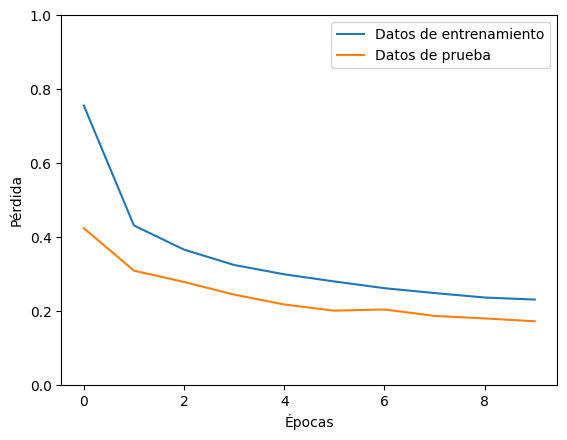

In [8]:
grafic(historial)

## Exportando el modelo

Una vez que el modelo haya sido entrenado ahora necesitamos exportarlo para hacer uso del mismo dentro del ámbito en desarrollo.

In [9]:
m.save(filepath="trainedModel/handwritting.h5")

/home/jonasaray/Documents/UCAB/Decimo/Inteligencia artificial/Proyecto/LetterRecognition/venv/lib/python3.12/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Pruebas

Por medio de creación de imagenes podemos verificar que el modelo funciona como esperamos.

In [3]:
m = models.load_model("trainedModel/handwritting.h5")

In [6]:
prueba = m.predict(df_test)

2024-05-06 10:15:33.083017: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92825600 exceeds 10% of free system memory.


463/463 [==============================] - 5s 688us/step


In [11]:
LETTERS = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
index = np.argmax(prueba[1269])
print(LETTERS[index-1])

n
